In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


def show_image(img, title: str = ""):
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))

    plt.axis("off")
    if title != "":
        plt.title(title)
    plt.show()


image_url = "dataset/IMG_20231028_165823.jpg"

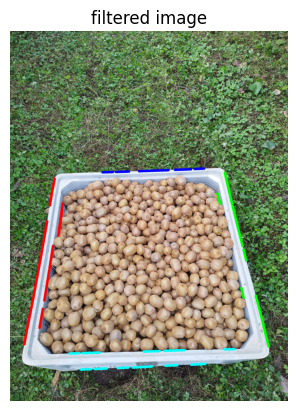

In [4]:
angles = []

def filter_lines(image_path):
    # Read the image
    image = cv2.imread(image_path)
    MIN_AVG = np.array([79,0,179], np.uint8)
    MAX_AVG = np.array([128,255,255], np.uint8)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    frame_threshed = cv2.inRange(hsv, MIN_AVG, MAX_AVG)
    frame_threshed = cv2.dilate(frame_threshed, kernel=(5,5), iterations=2)
    frame_threshed = cv2.erode(frame_threshed, kernel=(5,5), iterations=2)
    
    # Apply Canny edge detection
    edges = cv2.Canny(frame_threshed, 50, 150)

    # Apply Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)

    # Initialize lists to store lines in different groups
    left_lines, right_lines, top_lines, bottom_lines, gen_lines = [], [], [], [], []

    # Define the center of the image
    image_center_x = image.shape[1] // 2
    image_center_y = image.shape[0] // 2
    for line in lines:
        x1, y1, x2, y2 = line[0]

        # Calculate the slope of the line
        slope = (y2 - y1) / (x2 - x1) if (x2 - x1) != 0 else np.inf
        angle = (np.degrees(np.arctan(slope)))
        angles.append(angle)

        # Classify lines into left, right, top, and bottom groups based on angle and position
        if -90< angle < -10 and x1 < image_center_x and x2 < image_center_x:
            left_lines.append(line)
        elif 10 < angle < 90 and x1 > image_center_x and x2 > image_center_x:
            right_lines.append(line)
        elif -10 <= angle <= 10 and y1 < image_center_y and y2 < image_center_y:
            top_lines.append(line)
        elif -10 <= angle <= 10 and y1 > image_center_y and y2 > image_center_y:
            bottom_lines.append(line)
        else:
            gen_lines.append(line)

    dimg = image.copy()
    # Draw lines of each group with different colors
    draw_lines(dimg, left_lines, color=(0, 0, 255))  # Red
    draw_lines(dimg, right_lines, color=(0, 255, 0))  # Green
    draw_lines(dimg, top_lines, color=(255, 0, 0))  # Blue
    draw_lines(dimg, bottom_lines, color=(255, 255, 0))  # Yellow
    draw_lines(dimg, gen_lines, color=(255, 0, 255))  # Yellow

    # Display the result
    show_image(dimg, "filtered image")

    return left_lines, right_lines, top_lines, bottom_lines

def draw_lines(image, lines, color=(0, 255, 0), thickness=25):
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), color, thickness)

# Example usage
left_lines, right_lines, top_lines, bottom_lines = filter_lines(image_url)

In [5]:
# TODO: find a good way to select the sides.
# Now, I want to:
# - if lines are all (by some degree of freedom) parallel to eachother select the ones outermost the center of the image, avg them and project their straight line
# - if they are not enough parallel calculate the average and project its straight line

In [6]:
#_lines, top_lines, bottom_lines])

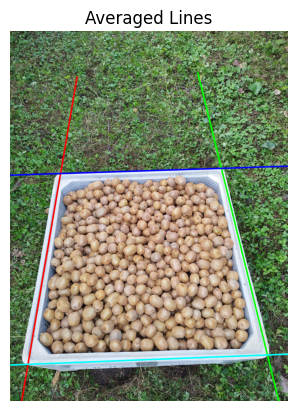

In [10]:
def project_avg_line(image, lines, color=(0, 255, 0), thickness=2):
    if len(lines) == 0:
        return

    # Extract angles and positions of all lines
    angles = [np.degrees(np.arctan2(line[0][3] - line[0][1], line[0][2] - line[0][0])) for line in lines]
    positions = np.array([[(line[0][0] + line[0][2]) / 2, (line[0][1] + line[0][3]) / 2] for line in lines], dtype=np.float32)

    # Calculate the average angle and position
    avg_angle = np.mean(angles)
    avg_position = np.mean(positions, axis=0)

    # Calculate the start and end points of the averaged line
    length = max(image.shape[0], image.shape[1]) // 2
    x1 = int(avg_position[0] - length * np.cos(np.radians(avg_angle)))
    y1 = int(avg_position[1] - length * np.sin(np.radians(avg_angle)))
    x2 = int(avg_position[0] + length * np.cos(np.radians(avg_angle)))
    y2 = int(avg_position[1] + length * np.sin(np.radians(avg_angle)))

    # Draw the averaged line
    cv2.line(image, (x1, y1), (x2, y2), color, thickness)

# Example usage
image_lines = cv2.imread(image_url)

# Assuming left_lines, right_lines, top_lines, bottom_lines are already obtained
project_avg_line(image_lines, left_lines, color=(0, 0, 255), thickness=15)
project_avg_line(image_lines, right_lines, color=(0, 255, 0), thickness=15)
project_avg_line(image_lines, top_lines, color=(255, 0, 0), thickness=15)
project_avg_line(image_lines, bottom_lines, color=(255, 255, 0), thickness=15)

show_image(image_lines, 'Averaged Lines')